In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import seaborn as sns
import albumentations as A
from skimage.exposure import rescale_intensity


import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2hed, hed2rgb

In [2]:
def imageProcessing2(df):

        #img = cv2.imread(df)
        # Example IHC image
        ihc_rgb = df#img

        # Separate the stains from the IHC image
        ihc_hed = rgb2hed(ihc_rgb)

        # Create an RGB image for each of the stains
        null = np.zeros_like(ihc_hed[:, :, 0])
        ihc_d = hed2rgb(np.stack((ihc_hed[:, :, 2], null, null), axis=-1))

        ihc_d = ihc_d*255      

   

        image1 = ihc_d.astype('uint8')
   
        # cv2.cvtColor is applied over the
        # image input with applied parameters
        # to convert the image in grayscale 
        image_result = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)


        return image_result

Declaration of a simple preprocessor function.  Preprocessor functions are used to preprocess an instance before labeling it. We use @preprocessor(name,resources) decorator to declare a function as preprocessor.

In [30]:
#from spear.labeling import preprocessor

#@preprocessor(name = "noise_removal")
def imagePreProcessing(df):

        img = cv2.imread(df)
        #Noise Removing
        image = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
        #Gaussian Blur
        gaussian_3 = cv2.GaussianBlur(image, (9,9), 10.0) #unblur
        image = cv2.addWeighted(image, 1.5, gaussian_3, -0.5, 0, image)
        #Laplacian Filter
        #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        #image = cv2.filter2D(image, -1, kernel)
        return image

In [31]:
pre_processed = imagePreProcessing("/content/image_3.png")

This is the Input Image

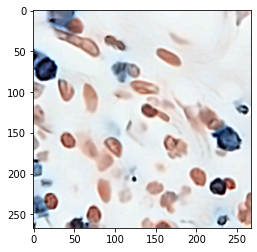

In [32]:
plt.imshow(pre_processed)
plt.show()

This is only hematoxylin-channel of image

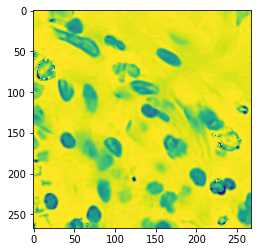

In [33]:
processed2 = imageProcessing2(pre_processed) 
plt.imshow(processed2)
plt.show()

In [34]:

#@labeling_function(resources=dict(keywords=trigWord1),pre=[convert_to_lower],label=ClassLabels.SPAM)
def LF2(c,d): 
    
    image = d
    img = c
    # applying different thresholding 
    # techniques on the input image
    # Otsu's thresholding after Gaussian filtering
    # Apply GaussianBlur to reduce image noise if it is required

    blur = cv2.GaussianBlur(img,(5,5),0)
    otsu_threshold, image_result = cv2.threshold(
         blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
    
    thresh2 = 255-image_result

    output = cv2.connectedComponentsWithStats(thresh2)
    (numLabels, labels, stats, centroids) = output
    mask = np.zeros(thresh2.shape, dtype="uint8")

    # loop over the number of unique connected component labels, skipping
    # over the first label (as label zero is the background)
    for i in range(1, numLabels):
        # extract the connected component statistics for the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
    
        # ensure the width, height, and area are all neither too small
        # nor too big
        #keepWidth = w > 5 and w < 30
        #keepHeight = h > 5 and h < 30
        #keepArea = area > 10

        keepWidth = w > 20
        keepHeight = h > 20
        keepArea = 100 < area < 2500
        # ensure the connected component we are examining passes all
        # three tests
        if all((keepWidth, keepHeight, keepArea)):
            # construct a mask for the current connected component and
            # then take the bitwise OR with the mask       
            componentMask = (labels == i).astype("uint8") * 1
            mask = cv2.bitwise_or(mask, componentMask)


        # Multiple objects
        result = image.copy()
        contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        colour = (255, 0, 0)
        thickness = 1
        i = 0
        
        bounding_boxes = []
       # Iterate through the contours and find bounding boxes
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append([x, y, x+w, y+h])
            cv2.rectangle(result, (x, y), (x+w, y+h), colour, thickness)
  

    return result, bounding_boxes


In [35]:
result, bounding_boxes2 = LF2(processed2, pre_processed)


The bounding boxes on H-channel of image

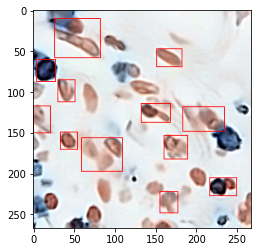

In [36]:
plt.imshow(result)

In [37]:
bounding_boxes2

[[155, 222, 177, 248],
 [216, 205, 249, 227],
 [59, 156, 109, 197],
 [160, 153, 189, 182],
 [33, 149, 54, 170],
 [183, 118, 234, 148],
 [0, 117, 21, 150],
 [132, 114, 168, 137],
 [30, 85, 51, 112],
 [4, 60, 27, 87],
 [151, 47, 182, 69],
 [26, 10, 82, 58]]

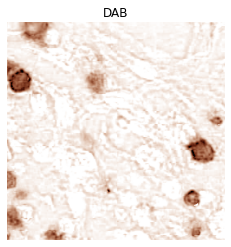

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Read in image from path
path = "/content/image_3.png"
ihc_rgb = io.imread(path)

# Separate the stains from the IHC image
ihc_hed = rgb2hed(ihc_rgb)

# Create an RGB image for the DAB stain
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

# Display DAB stain
plt.imshow(ihc_d)
plt.title("DAB")
plt.axis('off')
plt.show()


Bounding boxes from h-based translated to dab-based image to calculate brown score

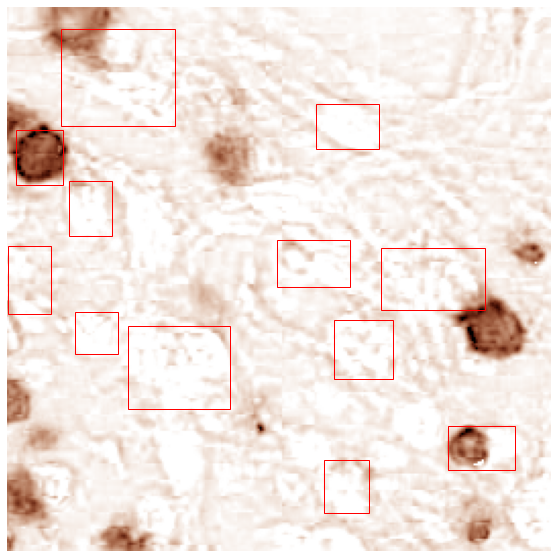

In [39]:
from PIL import Image
from matplotlib.patches import Rectangle

def draw_bounding_boxes(ihc_d, bounding_boxes, output_path):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(ihc_d)
    for bbox in bounding_boxes:
        x1, y1, x2, y2 = bbox
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')  # remove axis
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    im = Image.open(output_path)
    im = im.resize((267,267), Image.ANTIALIAS)
    im.save(output_path)

bounding_boxes = bounding_boxes2

draw_bounding_boxes(ihc_d, bounding_boxes, 'output.jpg')



Bounding box [155, 222, 177, 248] has brown score of 0.01048951048951049
Bounding box [216, 205, 249, 227] has brown score of 0.11570247933884298
Bounding box [59, 156, 109, 197] has brown score of 0.003902439024390244
Bounding box [160, 153, 189, 182] has brown score of 0.0
Bounding box [33, 149, 54, 170] has brown score of 0.0
Bounding box [183, 118, 234, 148] has brown score of 0.006535947712418301
Bounding box [0, 117, 21, 150] has brown score of 0.005772005772005772
Bounding box [132, 114, 168, 137] has brown score of 0.0
Bounding box [30, 85, 51, 112] has brown score of 0.003527336860670194
Bounding box [4, 60, 27, 87] has brown score of 0.09500805152979067
Bounding box [151, 47, 182, 69] has brown score of 0.0
Bounding box [26, 10, 82, 58] has brown score of 0.036458333333333336


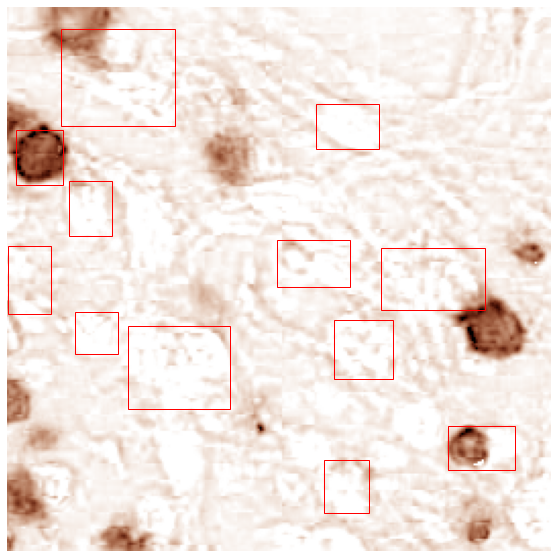

In [40]:
from PIL import Image

def get_brown_score(im, x1, y1, x2, y2):
    # Crop image to bounding box
    crop_im = im.crop((x1, y1, x2, y2))
    
    # Convert image to RGB
    crop_im = crop_im.convert("RGB")
    
    # Initialize brown pixel count
    brown_pixels = 0
    
    # Iterate over all pixels in the bounding box
    for x in range(crop_im.size[0]):
        for y in range(crop_im.size[1]):
            # Get RGB values of the pixel
            r, g, b = crop_im.getpixel((x, y))
            
            # Check if pixel is brown (within a certain range of R, G, B values)
            if 150 <= r <= 255 and 100 <= g <= 150 and 0 <= b <= 100:
                brown_pixels += 1
    
    # Calculate brown score (ratio of brown pixels to total pixels)
    brown_score = brown_pixels / (crop_im.size[0] * crop_im.size[1])
    
    return brown_score

def draw_bounding_boxes(ihc_d, bounding_boxes, output_path):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(ihc_d)
    for bbox in bounding_boxes:
        x1, y1, x2, y2 = bbox
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')  # remove axis
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    im = Image.open(output_path)
    im = im.resize((267,267), Image.ANTIALIAS)
    im.save(output_path)
    brown_scores = []
    for bbox in bounding_boxes:
        x1, y1, x2, y2 = bbox
        brown_score = get_brown_score(im, x1, y1, x2, y2)
        brown_scores.append(brown_score)
        print(f"Bounding box {bbox} has brown score of {brown_score}")
    return brown_scores

bounding_boxes = bounding_boxes2

brown_scores = draw_bounding_boxes(ihc_d, bounding_boxes, 'output.jpg')


Bounding box [94, 228, 124, 259] has brown score of 0.0
Bounding box [242, 195, 267, 237] has brown score of 0.0
Bounding box [39, 195, 69, 222] has brown score of 0.0
Bounding box [63, 186, 88, 209] has brown score of 0.0
Bounding box [11, 152, 43, 182] has brown score of 0.0
Bounding box [55, 134, 88, 159] has brown score of 0.1006060606060606
Bounding box [181, 112, 213, 173] has brown score of 0.0
Bounding box [157, 58, 180, 87] has brown score of 0.0
Bounding box [7, 6, 48, 39] has brown score of 0.0
Bounding box [139, 0, 167, 30] has brown score of 0.0
[[55, 134, 88, 159]]


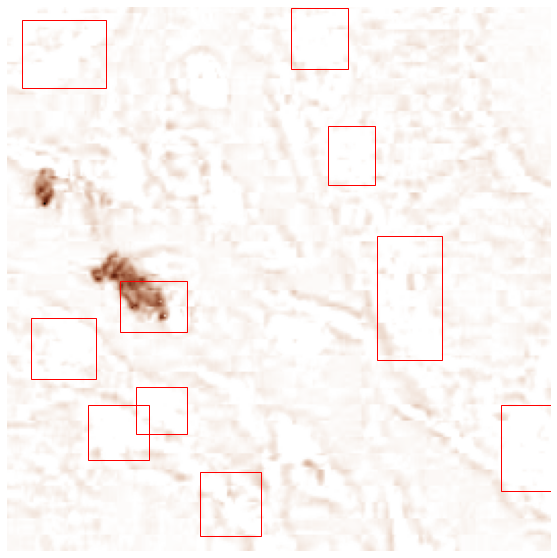

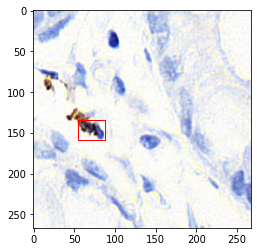

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image

folder_path = '/content/drive/MyDrive/Hematoxylin-Brown-Score/raw-images'

def get_brown_score(im, x1, y1, x2, y2):
    # Crop image to bounding box
    crop_im = im.crop((x1, y1, x2, y2))
    
    # Convert image to RGB
    crop_im = crop_im.convert("RGB")
    
    # Initialize brown pixel count
    brown_pixels = 0
    
    # Iterate over all pixels in the bounding box
    for x in range(crop_im.size[0]):
        for y in range(crop_im.size[1]):
            # Get RGB values of the pixel
            r, g, b = crop_im.getpixel((x, y))
            
            # Check if pixel is brown (within a certain range of R, G, B values)
            if 150 <= r <= 255 and 100 <= g <= 150 and 0 <= b <= 100:
                brown_pixels += 1
    
    # Calculate brown score (ratio of brown pixels to total pixels)
    brown_score = brown_pixels / (crop_im.size[0] * crop_im.size[1])
    
    return brown_score



for i in range(1):
    # Read in image from path
    path =f"/content/image_{i}.png"
    ihc_rgb = io.imread(path)
    im = Image.open(path)
    # Separate the stains from the IHC image
    ihc_hed = rgb2hed(ihc_rgb)

    # Create an RGB image for the DAB stain
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

    output_path = f"output_{i}.jpg"

    pre_processed = imagePreProcessing(path)
    processed2 = imageProcessing2(pre_processed)
    result, bounding_boxes1 = LF2(processed2,pre_processed)
    bounding_boxes_b = bounding_boxes1

    brown_scores = draw_bounding_boxes(ihc_d, bounding_boxes_b, output_path)
    bounding_boxes = []
    for j in range(len(bounding_boxes_b)):
        
        if brown_scores[j] > 0:
            bounding_boxes.append(bounding_boxes_b[j])



    print(bounding_boxes)
    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(im)

    # Draw rectangles for each bounding box
    for bb in bounding_boxes:
        rect = Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()
    # Iterate through the bounding boxes
    for j, box in enumerate(bounding_boxes):
        x1, y1, x2, y2 = box
        # Crop the image to the bounding box
        cropped_im = im.crop((x1, y1, x2, y2))
        # Save the cropped image with a unique name
        #cropped_im.save(f"{folder_path}/image-{i}_box_{j}.png") 
        

